In [18]:
#CODE RUN ON GOOGLE COLAB

from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.metrics import mean_absolute_error
import json
import numpy as np

In [19]:
def compute_mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [20]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [21]:
dataset=pd.read_csv('eplusout_3years.csv')
dataset=dataset.drop(columns=['Unnamed: 0'])

with open('opt_settings.JSON', 'r') as f:
        datastore = json.load(f)

opt_units=datastore['opt_units']
opt_e=datastore['opt_e']
opt_bs=datastore['opt_bs']
opt_stamps=datastore['opt_stamps']

dataset.head()

,avg_T_in,Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep),Environment:Site Outdoor Air Dewpoint Temperature [C](TimeStep),Environment:Site Outdoor Air Barometric Pressure [Pa](TimeStep),Environment:Site Wind Speed [m/s](TimeStep),Environment:Site Wind Direction [deg](TimeStep),Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](TimeStep),Environment:Site Direct Solar Radiation Rate per Area [W/m2](TimeStep),Environment:Site Solar Azimuth Angle [deg](TimeStep),Environment:Site Solar Altitude Angle [deg](TimeStep),Whole Building:Facility Total Produced Electric Energy [J](TimeStep),Electricity:Facility [J](TimeStep),InteriorEquipment:Electricity [J](TimeStep),InteriorLights:Electricity [J](TimeStep),DistrictCooling:Facility [J](TimeStep),DistrictHeating:Facility [J](TimeStep),Carbon Equivalent:Facility [kg](TimeStep)
0,18.082821,9.027778,3.083333,102566.666667,2.421398,9.375,0.0,0.0,16.238421,-74.674509,0.0,25528.643849,25528.643849,0.0,0.0,115044.390624,0.0
1,18.076854,9.444444,3.266667,102533.333333,2.607659,7.500,0.0,0.0,7.554051,-75.081983,0.0,25528.643849,25528.643849,0.0,0.0,108907.647720,0.0
2,18.071272,9.861111,3.450000,102500.000000,2.793920,5.625,0.0,0.0,1.409081,-75.187948,0.0,25528.643849,25528.643849,0.0,0.0,102525.455986,0.0
3,18.066188,10.277778,3.633333,102466.666667,2.980182,3.750,0.0,0.0,10.318985,-74.985968,0.0,25528.643849,25528.643849,0.0,0.0,95889.187315,0.0
4,18.061773,10.694444,3.816667,102433.333333,3.166443,1.875,0.0,0.0,18.856027,-74.488165,0.0,25528.643849,25528.643849,0.0,0.0,89397.078196,0.0


In [22]:
# load dataset
values=dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of features
n_features = len(list(dataset.columns)) #number of columns in dataset
n_output = 18 # 3hrs
n_train_stamps = 2*364*24*6 #2 years
# list to store the results
results=[]
# list of titles for plots
titles=[]

In [23]:
def Reframing(n_stamps, n_output=n_output, scaled=scaled, n_train_stamps = n_train_stamps):

  # frame as supervised learning
    reframed = series_to_supervised(scaled, n_stamps, n_output)

    # split into train and test sets
    values = reframed.values
    train = values[:n_train_stamps, :]
    test = values[n_train_stamps:, :]

    # split into input and outputs
    n_obs = n_stamps * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_stamps, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_stamps, n_features))
    
    return train_X, train_y, test_X, test_y

In [24]:
def PlotResult(d, case, dataset=dataset, n_train_stamps = n_train_stamps):

  filename=f"n_stamps{d['n_stamps']}_epochs{d['epochs']}_batchsize{d['batch_size']}_n_units{d['n_units']}"
  history=d['history']
  inv_yhat=d['inv_yhat']

  # plot history
  fig0 = pyplot.figure()
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='test')
  pyplot.xlabel('Epoch')
  pyplot.ylabel('Loss (MAE)')
  pyplot.title('Loss (MAE) for '+ case)
  pyplot.legend()
  fig0.savefig(filename+'_loss.png', dpi=120)
  pyplot.show()

  # plot prediction
  fig1 = pyplot.figure()
  pyplot.plot(dataset['avg_T_in'][n_train_stamps:].values, label='Real')
  pyplot.plot(inv_yhat, label='Predicted')
  pyplot.legend()
  pyplot.xlabel('Timestamp')
  pyplot.ylabel('Tin (°C)')
  pyplot.title("Real Tin vs. Predicted Tin for "+ case)
  fig1.savefig(filename+'_results.png', dpi=120)
  print(fig1.dpi)
  pyplot.show()

In [26]:
def ChangeModel(n_units=50, e=10, bs=72, n_stamps=6, n_output=n_output, scaled=scaled, to_reframe=False, *args):
  
  if to_reframe:
    train_X, train_y, test_X, test_y = Reframing(n_stamps)
    print('reframed')
    
  else:
    train_X = args[0]
    train_y = args[1]
    test_X = args[2]
    test_y = args[3]


  # design network
  model = Sequential()
  model.add(LSTM(n_units, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dense(1))
  model.compile(loss='mae', optimizer='adam')

  # fit network
  history = model.fit(train_X, train_y, epochs=e, batch_size=bs, validation_data=(test_X, test_y), verbose=2, shuffle=False)
  


  # make a prediction
  yhat = model.predict(test_X)
  test_X = test_X.reshape((test_X.shape[0], n_stamps*n_features))
  
  # invert scaling for forecast
  inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
  inv_yhat = scaler.inverse_transform(inv_yhat)
  inv_yhat = inv_yhat[:,0]
  
  # invert scaling for actual
  test_y = test_y.reshape((len(test_y), 1))
  inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
  inv_y = scaler.inverse_transform(inv_y)
  inv_y = inv_y[:,0]
  
  # calculate RMSE and MAE
  rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
  mae = mean_absolute_error(inv_y, inv_yhat)
  mape= compute_mape(inv_y, inv_yhat)
  d={'n_units': n_units, 'epochs': e, 'batch_size':bs, 'n_stamps': n_stamps, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, "history": history, "inv_yhat": inv_yhat}
  print('\n', d)
  #print('Test RMSE: %.3f' % rmse)

  return d

In [ ]:
# first choice for parameters
#train_X, train_y, test_X, test_y = Reframing(1, n_output=n_output)
#results.append(ChangeModel(50, 10, 72, 1, n_output, scaled, False, train_X, train_y, test_X, test_y))
#titles.append('Initial choice parmas. (3 hours prediction)')

Epoch 1/10
1456/1456 - 5s - loss: 0.0668 - val_loss: 0.0790
Epoch 2/10
1456/1456 - 4s - loss: 0.0274 - val_loss: 0.0682
Epoch 3/10
1456/1456 - 4s - loss: 0.0250 - val_loss: 0.0647
Epoch 4/10
1456/1456 - 3s - loss: 0.0233 - val_loss: 0.0650
Epoch 5/10
1456/1456 - 4s - loss: 0.0219 - val_loss: 0.0701
Epoch 6/10
1456/1456 - 4s - loss: 0.0210 - val_loss: 0.0700
Epoch 7/10
1456/1456 - 4s - loss: 0.0201 - val_loss: 0.0734
Epoch 8/10
1456/1456 - 4s - loss: 0.0200 - val_loss: 0.0739
Epoch 9/10
1456/1456 - 4s - loss: 0.0192 - val_loss: 0.0723
Epoch 10/10
1456/1456 - 3s - loss: 0.0191 - val_loss: 0.0695

 {'n_units': 50, 'epochs': 10, 'batch_size': 72, 'n_stamps': 1, 'RMSE': 0.7201006265364979, 'MAE': 0.6231147, 'MAPE': 2.6710692793130875, 'history': <keras.callbacks.History object at 0x7fdae0629fd0>, 'inv_yhat': array([17.831617, 17.790007, 17.765553, ..., 17.789532, 17.780863,
       17.772009], dtype=float32)}


In [ ]:
# optimal parameters
#train_X, train_y, test_X, test_y = Reframing(opt_stamps)
#results.append(ChangeModel(opt_units, opt_e, opt_bs, opt_stamps, n_output, scaled, False, train_X, train_y, test_X, test_y))
#titles.append('Optimal params. (3 hours prediction)')

Epoch 1/30
1456/1456 - 83s - loss: 0.0574 - val_loss: 0.0504
Epoch 2/30
1456/1456 - 74s - loss: 0.0279 - val_loss: 0.0346
Epoch 3/30
1456/1456 - 75s - loss: 0.0231 - val_loss: 0.0487
Epoch 4/30
1456/1456 - 75s - loss: 0.0207 - val_loss: 0.0281
Epoch 5/30
1456/1456 - 76s - loss: 0.0192 - val_loss: 0.0348
Epoch 6/30
1456/1456 - 74s - loss: 0.0181 - val_loss: 0.0476
Epoch 7/30
1456/1456 - 75s - loss: 0.0182 - val_loss: 0.0303
Epoch 8/30
1456/1456 - 74s - loss: 0.0171 - val_loss: 0.0510
Epoch 9/30
1456/1456 - 77s - loss: 0.0167 - val_loss: 0.0442
Epoch 10/30
1456/1456 - 74s - loss: 0.0164 - val_loss: 0.0276
Epoch 11/30
1456/1456 - 74s - loss: 0.0148 - val_loss: 0.0352
Epoch 12/30
1456/1456 - 75s - loss: 0.0162 - val_loss: 0.0452
Epoch 13/30
1456/1456 - 75s - loss: 0.0155 - val_loss: 0.0361
Epoch 14/30
1456/1456 - 75s - loss: 0.0157 - val_loss: 0.0410
Epoch 15/30
1456/1456 - 74s - loss: 0.0154 - val_loss: 0.0366
Epoch 16/30
1456/1456 - 75s - loss: 0.0148 - val_loss: 0.0459
Epoch 17/30
1456/

In [ ]:
# predict value 8hrs later
#train_X, train_y, test_X, test_y = Reframing(opt_stamps,n_output=48)
#results.append(ChangeModel(opt_units, opt_e, opt_bs, opt_stamps, 48, scaled, False, train_X, train_y, test_X, test_y))

Epoch 1/30
1456/1456 - 77s - loss: 0.0734 - val_loss: 0.1193
Epoch 2/30
1456/1456 - 74s - loss: 0.0374 - val_loss: 0.1272
Epoch 3/30
1456/1456 - 74s - loss: 0.0318 - val_loss: 0.1099
Epoch 4/30
1456/1456 - 73s - loss: 0.0298 - val_loss: 0.1205
Epoch 5/30
1456/1456 - 73s - loss: 0.0285 - val_loss: 0.1209
Epoch 6/30
1456/1456 - 77s - loss: 0.0276 - val_loss: 0.1109
Epoch 7/30
1456/1456 - 74s - loss: 0.0265 - val_loss: 0.1059
Epoch 8/30
1456/1456 - 74s - loss: 0.0260 - val_loss: 0.0959
Epoch 9/30
1456/1456 - 74s - loss: 0.0250 - val_loss: 0.0899
Epoch 10/30
1456/1456 - 74s - loss: 0.0245 - val_loss: 0.0822
Epoch 11/30
1456/1456 - 74s - loss: 0.0241 - val_loss: 0.0791
Epoch 12/30
1456/1456 - 74s - loss: 0.0236 - val_loss: 0.0752
Epoch 13/30
1456/1456 - 74s - loss: 0.0232 - val_loss: 0.0733
Epoch 14/30
1456/1456 - 77s - loss: 0.0232 - val_loss: 0.0727
Epoch 15/30
1456/1456 - 74s - loss: 0.0229 - val_loss: 0.0718
Epoch 16/30
1456/1456 - 74s - loss: 0.0226 - val_loss: 0.0704
Epoch 17/30
1456/

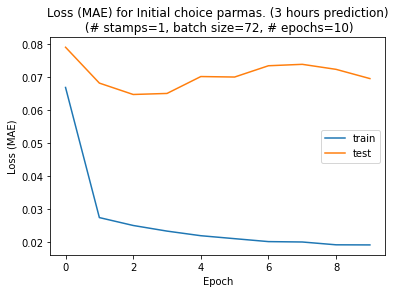

72.0


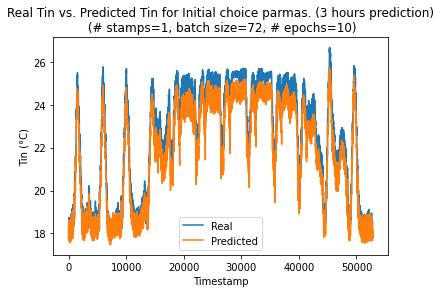

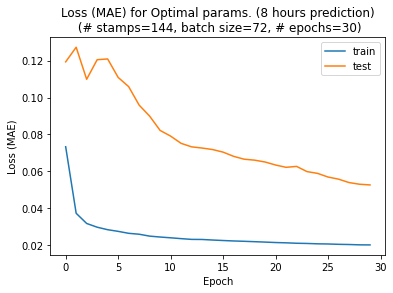

72.0


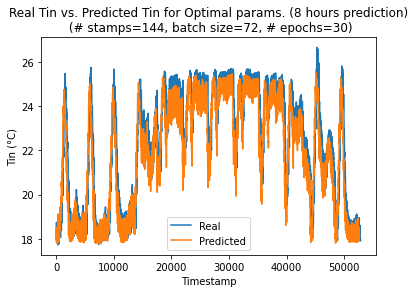

In [ ]:
'''
t=0
for res in results:
  PlotResult(res, f"{titles[t]}\n (# stamps={res['n_stamps']}, batch size={res['batch_size']}, # epochs={res['epochs']})")
  t+=1
'''

In [27]:
# NEW! Predict value 8hrs later using the optimal parameters for the 8-hours prediction

with open('opt_settings_8hrs.JSON', 'r') as f:
        datastore = json.load(f)
     
opt_units=datastore['opt_units']
opt_e=datastore['opt_e']
opt_bs=datastore['opt_bs']
opt_stamps=datastore['opt_stamps']

train_X, train_y, test_X, test_y = Reframing(opt_stamps,n_output=48)
res = ChangeModel(opt_units, opt_e, opt_bs, opt_stamps, 48, scaled, False, train_X, train_y, test_X, test_y)
results.append(res)

Epoch 1/30
364/364 - 10s - loss: 0.0673 - val_loss: 0.0601
Epoch 2/30
364/364 - 9s - loss: 0.0364 - val_loss: 0.0639
Epoch 3/30
364/364 - 9s - loss: 0.0366 - val_loss: 0.0445
Epoch 4/30
364/364 - 9s - loss: 0.0333 - val_loss: 0.0345
Epoch 5/30
364/364 - 8s - loss: 0.0329 - val_loss: 0.0425
Epoch 6/30
364/364 - 9s - loss: 0.0314 - val_loss: 0.0439
Epoch 7/30
364/364 - 9s - loss: 0.0294 - val_loss: 0.0420
Epoch 8/30
364/364 - 9s - loss: 0.0281 - val_loss: 0.0551
Epoch 9/30
364/364 - 9s - loss: 0.0274 - val_loss: 0.0507
Epoch 10/30
364/364 - 9s - loss: 0.0268 - val_loss: 0.0454
Epoch 11/30
364/364 - 8s - loss: 0.0259 - val_loss: 0.0532
Epoch 12/30
364/364 - 9s - loss: 0.0255 - val_loss: 0.0450
Epoch 13/30
364/364 - 9s - loss: 0.0250 - val_loss: 0.0473
Epoch 14/30
364/364 - 9s - loss: 0.0248 - val_loss: 0.0371
Epoch 15/30
364/364 - 8s - loss: 0.0249 - val_loss: 0.0342
Epoch 16/30
364/364 - 9s - loss: 0.0249 - val_loss: 0.0335
Epoch 17/30
364/364 - 9s - loss: 0.0245 - val_loss: 0.0358
Epoch

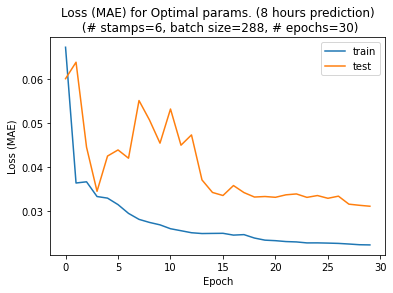

72.0


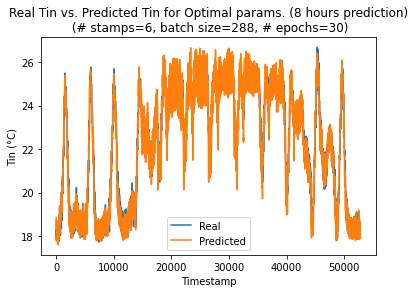

In [28]:
# plot result
title_8hrs= 'Optimal params. (8 hours prediction)'
PlotResult(res, f"{title_8hrs}\n (# stamps={res['n_stamps']}, batch size={res['batch_size']}, # epochs={res['epochs']})")